# Zero-Shot Land Cover Classification of SAR-like Imagery using Vision-Language Models: A Comprehensive Prompt Engineering Study

---


In [1]:
!pip install -q torch torchvision transformers matplotlib numpy scikit-learn seaborn tqdm pillow ftfy regex datasets scipy
!pip install -q git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from scipy import stats
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

OUTPUT_DIR = '/content/results_v2'
os.makedirs(OUTPUT_DIR, exist_ok=True)

Device: cuda


In [3]:
from datasets import load_dataset

print('Loading FULL EuroSAT dataset from HuggingFace...')
eurosat_train = load_dataset('tanganke/eurosat', split='train')
eurosat_test = load_dataset('tanganke/eurosat', split='test')

# Combine for larger evaluation
from datasets import concatenate_datasets
eurosat_full = concatenate_datasets([eurosat_train, eurosat_test])
print(f'Full dataset: {len(eurosat_full)} images')

CLASS_NAMES = eurosat_full.features['label'].names
NUM_CLASSES = len(CLASS_NAMES)
print(f'Classes ({NUM_CLASSES}): {CLASS_NAMES}')

Loading FULL EuroSAT dataset from HuggingFace...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/73.5M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/9.13M [00:00<?, ?B/s]

data/contrast-00000-of-00001.parquet:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

data/gaussian_noise-00000-of-00001.parqu(…):   0%|          | 0.00/3.38M [00:00<?, ?B/s]

data/impulse_noise-00000-of-00001.parque(…):   0%|          | 0.00/3.60M [00:00<?, ?B/s]

data/jpeg_compression-00000-of-00001.par(…):   0%|          | 0.00/1.83M [00:00<?, ?B/s]

data/motion_blur-00000-of-00001.parquet:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

data/pixelate-00000-of-00001.parquet:   0%|          | 0.00/766k [00:00<?, ?B/s]

data/spatter-00000-of-00001.parquet:   0%|          | 0.00/3.22M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/21600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating contrast split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating gaussian_noise split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating impulse_noise split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating jpeg_compression split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating motion_blur split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating pixelate split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Generating spatter split:   0%|          | 0/2700 [00:00<?, ? examples/s]

Full dataset: 24300 images
Classes (10): ['annual crop land', 'forest', 'brushland or shrubland', 'highway or road', 'industrial buildings or commercial buildings', 'pasture land', 'permanent crop land', 'residential buildings or homes or apartments', 'river', 'lake or sea']


In [4]:
# Human-readable names and hierarchical grouping
READABLE_NAMES = [
    'annual crop field',
    'forest',
    'herbaceous vegetation',
    'highway road',
    'industrial buildings',
    'pasture grassland',
    'permanent crop',
    'residential buildings',
    'river',
    'lake or sea'
]

# HIERARCHICAL GROUPING (Novelty #3)
HIERARCHY = {
    'Agriculture': [0, 6],        # annual crop, permanent crop
    'Vegetation': [1, 2, 5],      # forest, herbaceous, pasture
    'Built-up': [4, 7],           # industrial, residential
    'Infrastructure': [3],        # highway
    'Water': [8, 9]               # river, lake
}

# Reverse mapping: class_idx -> coarse_label
COARSE_LABELS = {}
COARSE_NAMES = list(HIERARCHY.keys())
for coarse_idx, (coarse_name, fine_indices) in enumerate(HIERARCHY.items()):
    for fine_idx in fine_indices:
        COARSE_LABELS[fine_idx] = coarse_idx

print('Hierarchical grouping:')
for name, indices in HIERARCHY.items():
    classes = [CLASS_NAMES[i] for i in indices]
    print(f'  {name}: {classes}')

Hierarchical grouping:
  Agriculture: ['annual crop land', 'permanent crop land']
  Vegetation: ['forest', 'brushland or shrubland', 'pasture land']
  Built-up: ['industrial buildings or commercial buildings', 'residential buildings or homes or apartments']
  Infrastructure: ['highway or road']
  Water: ['river', 'lake or sea']


In [5]:
# Load CLIP models
print('Loading CLIP models...')
model_b32, preprocess_b32 = clip.load('ViT-B/32', device=device)
model_l14, preprocess_l14 = clip.load('ViT-L/14', device=device)
print('✅ Models loaded!')

Loading CLIP models...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 284MiB/s]
100%|████████████████████████████████████████| 890M/890M [00:02<00:00, 390MiB/s]


✅ Models loaded!


In [6]:
class EuroSATDataset(Dataset):
    def __init__(self, hf_dataset, preprocess, use_grayscale=True):
        self.dataset = hf_dataset
        self.preprocess = preprocess
        self.use_grayscale = use_grayscale

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = item['image']
        label = item['label']
        coarse_label = COARSE_LABELS[label]

        if self.use_grayscale:
            gray = img.convert('L')
            img = Image.merge('RGB', (gray, gray, gray))

        img_tensor = self.preprocess(img)
        return img_tensor, label, coarse_label

# Create datasets - FULL SIZE
dataset_b32 = EuroSATDataset(eurosat_full, preprocess_b32, use_grayscale=True)
dataset_l14 = EuroSATDataset(eurosat_full, preprocess_l14, use_grayscale=True)

loader_b32 = DataLoader(dataset_b32, batch_size=128, shuffle=False, num_workers=4)
loader_l14 = DataLoader(dataset_l14, batch_size=64, shuffle=False, num_workers=4)

print(f'Dataset size: {len(dataset_b32)} images')

Dataset size: 24300 images


## 📝 Extended Prompt Engineering (10+ Prompts)


In [7]:
# EXTENDED PROMPT TEMPLATES (10+)
PROMPT_TEMPLATES = {
    # Basic prompts
    'generic': 'a satellite image of {}',
    'photo': 'a photo of {}',
    'aerial': 'an aerial view of {}',

    # SAR-specific prompts (Novel)
    'sar_basic': 'radar imagery showing {}',
    'sar_physics': 'SAR backscatter pattern of {}',
    'sar_texture': 'grayscale radar texture of {}',

    # Remote sensing prompts
    'sentinel': 'Sentinel satellite image of {}',
    'landcover': 'land cover classification of {}',

    # Structural prompts
    'structure': 'spatial pattern of {} from above',
    'texture_gray': 'grayscale texture pattern of {}',
}

# Coarse-level prompts for hierarchical classification
COARSE_READABLE = ['agricultural land', 'vegetated area', 'urban built-up area', 'transportation infrastructure', 'water body']

def create_text_embeddings(model, template, class_names):
    prompts = [template.format(name) for name in class_names]
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

def create_ensemble_embeddings(model, templates, class_names):
    all_embeddings = []
    for template in templates.values():
        emb = create_text_embeddings(model, template, class_names)
        all_embeddings.append(emb)
    return torch.stack(all_embeddings).mean(dim=0)

print(f'Total prompts: {len(PROMPT_TEMPLATES)}')
for name, template in PROMPT_TEMPLATES.items():
    print(f'  {name}: "{template.format("forest")}"')

Total prompts: 10
  generic: "a satellite image of forest"
  photo: "a photo of forest"
  aerial: "an aerial view of forest"
  sar_basic: "radar imagery showing forest"
  sar_physics: "SAR backscatter pattern of forest"
  sar_texture: "grayscale radar texture of forest"
  sentinel: "Sentinel satellite image of forest"
  landcover: "land cover classification of forest"
  structure: "spatial pattern of forest from above"
  texture_gray: "grayscale texture pattern of forest"


In [8]:
def zero_shot_classify(model, dataloader, text_features, desc='Classifying'):
    all_preds = []
    all_labels = []
    all_coarse_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels, coarse_labels in tqdm(dataloader, desc=desc):
            images = images.to(device)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            probs, preds = similarity.max(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_coarse_labels.extend(coarse_labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_coarse_labels), np.array(all_probs)

## 🔬 Experiment 1: Extended Prompt Comparison


In [9]:
# Run all prompt experiments
results = {}

for prompt_name, template in PROMPT_TEMPLATES.items():
    print(f'\n=== {prompt_name} ===')
    text_features = create_text_embeddings(model_b32, template, READABLE_NAMES)
    preds, labels, coarse_labels, probs = zero_shot_classify(model_b32, loader_b32, text_features, prompt_name)
    acc = accuracy_score(labels, preds)
    results[prompt_name] = {'accuracy': acc, 'preds': preds, 'labels': labels, 'coarse_labels': coarse_labels}
    print(f'Accuracy: {acc*100:.2f}%')

# Ensemble
print('\n=== ensemble ===')
text_ensemble = create_ensemble_embeddings(model_b32, PROMPT_TEMPLATES, READABLE_NAMES)
preds_ens, labels_ens, coarse_ens, probs_ens = zero_shot_classify(model_b32, loader_b32, text_ensemble, 'ensemble')
acc_ens = accuracy_score(labels_ens, preds_ens)
results['ensemble'] = {'accuracy': acc_ens, 'preds': preds_ens, 'labels': labels_ens, 'coarse_labels': coarse_ens}
print(f'Accuracy: {acc_ens*100:.2f}%')

print('\n=== Summary ===')
for name, data in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f'{name:15s}: {data["accuracy"]*100:.2f}%')


=== generic ===


generic:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 23.91%

=== photo ===


photo:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 27.09%

=== aerial ===


aerial:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 31.52%

=== sar_basic ===


sar_basic:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 24.27%

=== sar_physics ===


sar_physics:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 23.70%

=== sar_texture ===


sar_texture:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 23.80%

=== sentinel ===


sentinel:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 27.23%

=== landcover ===


landcover:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 22.00%

=== structure ===


structure:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 26.64%

=== texture_gray ===


texture_gray:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 29.71%

=== ensemble ===


ensemble:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 29.62%

=== Summary ===
aerial         : 31.52%
texture_gray   : 29.71%
ensemble       : 29.62%
sentinel       : 27.23%
photo          : 27.09%
structure      : 26.64%
sar_basic      : 24.27%
generic        : 23.91%
sar_texture    : 23.80%
sar_physics    : 23.70%
landcover      : 22.00%


## 📊 Statistical Significance (Bootstrap CI)


In [10]:
def bootstrap_ci(labels, preds, n_bootstraps=1000, ci=95):
    """Compute bootstrap confidence interval for accuracy."""
    accuracies = []
    n = len(labels)
    for _ in range(n_bootstraps):
        indices = np.random.choice(n, n, replace=True)
        acc = accuracy_score(labels[indices], preds[indices])
        accuracies.append(acc)

    lower = (100 - ci) / 2
    upper = 100 - lower
    ci_low, ci_high = np.percentile(accuracies, [lower, upper])
    return np.mean(accuracies), ci_low, ci_high

print('Computing bootstrap confidence intervals...')
ci_results = {}

for name, data in tqdm(results.items(), desc='Bootstrap'):
    mean_acc, ci_low, ci_high = bootstrap_ci(data['labels'], data['preds'])
    ci_results[name] = {'mean': mean_acc, 'ci_low': ci_low, 'ci_high': ci_high}

print('\n=== Results with 95% Confidence Intervals ===')
for name, ci in sorted(ci_results.items(), key=lambda x: x[1]['mean'], reverse=True):
    print(f"{name:15s}: {ci['mean']*100:.2f}% (95% CI: {ci['ci_low']*100:.2f}-{ci['ci_high']*100:.2f})")

Computing bootstrap confidence intervals...


Bootstrap:   0%|          | 0/11 [00:00<?, ?it/s]


=== Results with 95% Confidence Intervals ===
aerial         : 31.51% (95% CI: 30.92-32.07)
texture_gray   : 29.69% (95% CI: 29.12-30.30)
ensemble       : 29.64% (95% CI: 29.07-30.21)
sentinel       : 27.22% (95% CI: 26.69-27.81)
photo          : 27.09% (95% CI: 26.54-27.66)
structure      : 26.64% (95% CI: 26.07-27.23)
sar_basic      : 24.26% (95% CI: 23.72-24.79)
generic        : 23.90% (95% CI: 23.38-24.41)
sar_texture    : 23.81% (95% CI: 23.27-24.37)
sar_physics    : 23.70% (95% CI: 23.16-24.22)
landcover      : 22.02% (95% CI: 21.49-22.54)


## 🔬 Experiment 2: Hierarchical Classification


In [11]:
# Hierarchical Classification: First classify into coarse categories
print('\n=== Hierarchical Classification ===')

# Step 1: Coarse classification
text_coarse = create_text_embeddings(model_l14, 'a satellite image of {}', COARSE_READABLE)

# Create coarse dataset
coarse_preds = []
coarse_labels_all = []

with torch.no_grad():
    for images, labels, coarse_labels in tqdm(loader_l14, desc='Coarse classification'):
        images = images.to(device)
        image_features = model_l14.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_coarse.T).softmax(dim=-1)
        _, preds = similarity.max(dim=-1)
        coarse_preds.extend(preds.cpu().numpy())
        coarse_labels_all.extend(coarse_labels.numpy())

coarse_preds = np.array(coarse_preds)
coarse_labels_all = np.array(coarse_labels_all)
coarse_acc = accuracy_score(coarse_labels_all, coarse_preds)
print(f'\nCoarse-level accuracy (5 classes): {coarse_acc*100:.2f}%')


=== Hierarchical Classification ===


Coarse classification:   0%|          | 0/380 [00:00<?, ?it/s]


Coarse-level accuracy (5 classes): 44.26%


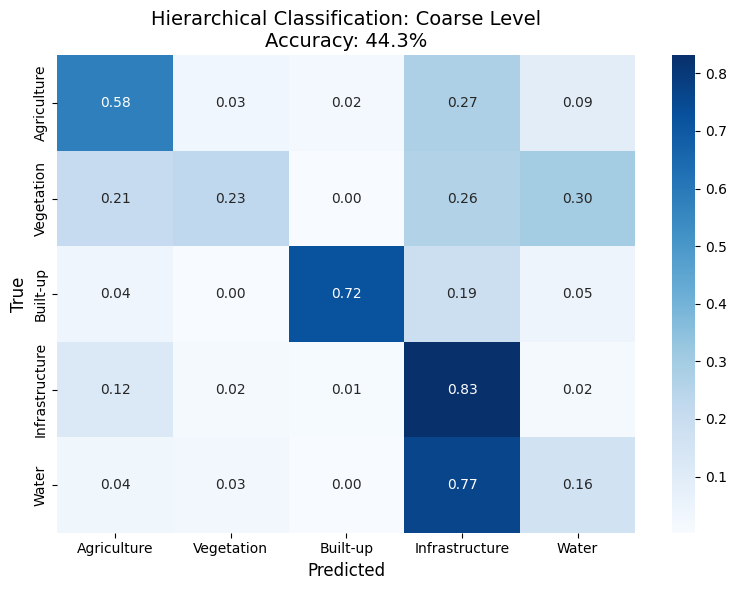

In [12]:
# Visualization: Coarse confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_coarse = confusion_matrix(coarse_labels_all, coarse_preds)
cm_coarse_norm = cm_coarse.astype('float') / cm_coarse.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_coarse_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=COARSE_NAMES, yticklabels=COARSE_NAMES, ax=ax)
ax.set_title(f'Hierarchical Classification: Coarse Level\nAccuracy: {coarse_acc*100:.1f}%', fontsize=14)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig_hierarchical_coarse.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔬 Experiment 3: Model Comparison with Statistical Tests


In [13]:
# Compare ViT-B/32 vs ViT-L/14
best_prompt = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
print(f'Using best prompt: {best_prompt}')

model_comparison = {}

# ViT-B/32
print('\n=== CLIP ViT-B/32 ===')
if best_prompt == 'ensemble':
    text_b32 = create_ensemble_embeddings(model_b32, PROMPT_TEMPLATES, READABLE_NAMES)
else:
    text_b32 = create_text_embeddings(model_b32, PROMPT_TEMPLATES[best_prompt], READABLE_NAMES)
preds_b32, labels_b32, coarse_b32, _ = zero_shot_classify(model_b32, loader_b32, text_b32, 'ViT-B/32')
acc_b32 = accuracy_score(labels_b32, preds_b32)
mean_b32, ci_low_b32, ci_high_b32 = bootstrap_ci(labels_b32, preds_b32)
model_comparison['CLIP ViT-B/32'] = {'acc': acc_b32, 'preds': preds_b32, 'labels': labels_b32, 'ci': (ci_low_b32, ci_high_b32)}
print(f'Accuracy: {acc_b32*100:.2f}% (95% CI: {ci_low_b32*100:.2f}-{ci_high_b32*100:.2f})')

# ViT-L/14
print('\n=== CLIP ViT-L/14 ===')
if best_prompt == 'ensemble':
    text_l14 = create_ensemble_embeddings(model_l14, PROMPT_TEMPLATES, READABLE_NAMES)
else:
    text_l14 = create_text_embeddings(model_l14, PROMPT_TEMPLATES[best_prompt], READABLE_NAMES)
preds_l14, labels_l14, coarse_l14, _ = zero_shot_classify(model_l14, loader_l14, text_l14, 'ViT-L/14')
acc_l14 = accuracy_score(labels_l14, preds_l14)
mean_l14, ci_low_l14, ci_high_l14 = bootstrap_ci(labels_l14, preds_l14)
model_comparison['CLIP ViT-L/14'] = {'acc': acc_l14, 'preds': preds_l14, 'labels': labels_l14, 'ci': (ci_low_l14, ci_high_l14)}
print(f'Accuracy: {acc_l14*100:.2f}% (95% CI: {ci_low_l14*100:.2f}-{ci_high_l14*100:.2f})')

# Statistical significance test
print('\n=== Statistical Significance ===')
# McNemar's test for paired classifiers
correct_b32 = (preds_b32 == labels_b32)
correct_l14 = (preds_l14 == labels_l14)
b = np.sum(correct_b32 & ~correct_l14)  # B/32 correct, L/14 wrong
c = np.sum(~correct_b32 & correct_l14)  # B/32 wrong, L/14 correct
mcnemar_stat = (abs(b - c) - 1)**2 / (b + c)
p_value = 1 - stats.chi2.cdf(mcnemar_stat, df=1)
print(f"McNemar's test: χ² = {mcnemar_stat:.2f}, p = {p_value:.4f}")
if p_value < 0.05:
    print('Result: ViT-L/14 is SIGNIFICANTLY better than ViT-B/32 (p < 0.05)')
else:
    print('Result: No significant difference between models')

Using best prompt: aerial

=== CLIP ViT-B/32 ===


ViT-B/32:   0%|          | 0/190 [00:00<?, ?it/s]

Accuracy: 31.52% (95% CI: 30.95-32.11)

=== CLIP ViT-L/14 ===


ViT-L/14:   0%|          | 0/380 [00:00<?, ?it/s]

Accuracy: 33.57% (95% CI: 32.98-34.17)

=== Statistical Significance ===
McNemar's test: χ² = 34.83, p = 0.0000
Result: ViT-L/14 is SIGNIFICANTLY better than ViT-B/32 (p < 0.05)


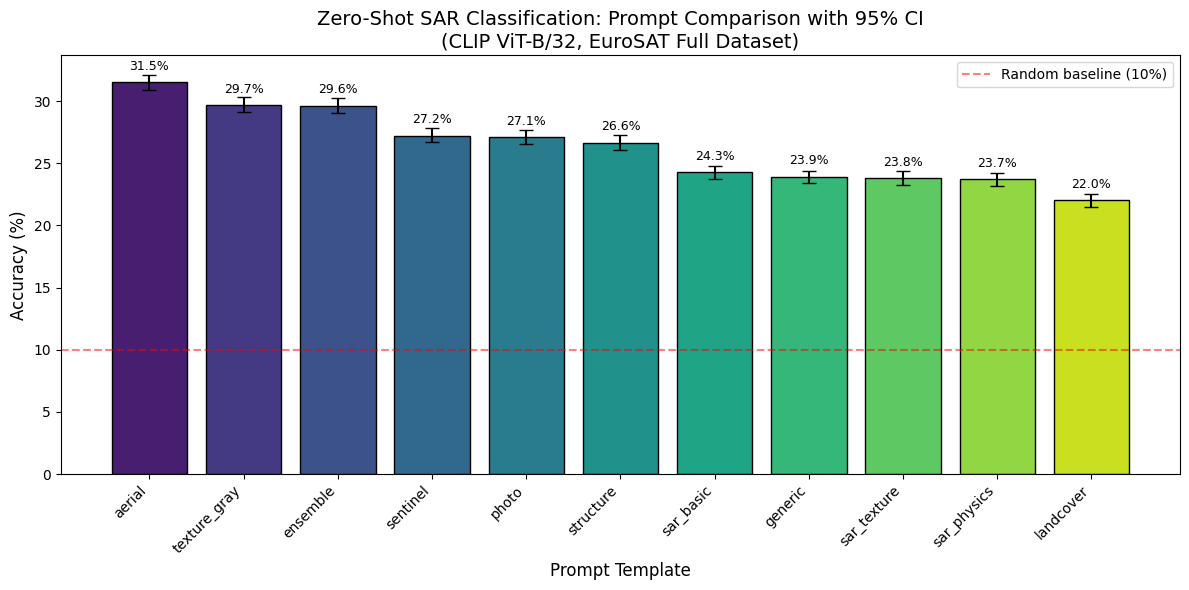

In [14]:
# Visualization: Prompt comparison with error bars
fig, ax = plt.subplots(figsize=(12, 6))

names = list(ci_results.keys())
means = [ci_results[n]['mean'] * 100 for n in names]
errors_low = [means[i] - ci_results[names[i]]['ci_low'] * 100 for i in range(len(names))]
errors_high = [ci_results[names[i]]['ci_high'] * 100 - means[i] for i in range(len(names))]

# Sort by accuracy
sorted_idx = np.argsort(means)[::-1]
names = [names[i] for i in sorted_idx]
means = [means[i] for i in sorted_idx]
errors_low = [errors_low[i] for i in sorted_idx]
errors_high = [errors_high[i] for i in sorted_idx]

colors = sns.color_palette('viridis', len(names))
bars = ax.bar(names, means, yerr=[errors_low, errors_high], capsize=5, color=colors, edgecolor='black')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlabel('Prompt Template', fontsize=12)
ax.set_title('Zero-Shot SAR Classification: Prompt Comparison with 95% CI\n(CLIP ViT-B/32, EuroSAT Full Dataset)', fontsize=14)
ax.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Random baseline (10%)')
ax.legend()

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{mean:.1f}%', ha='center', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig1_prompt_comparison_ci.png', dpi=300, bbox_inches='tight')
plt.show()

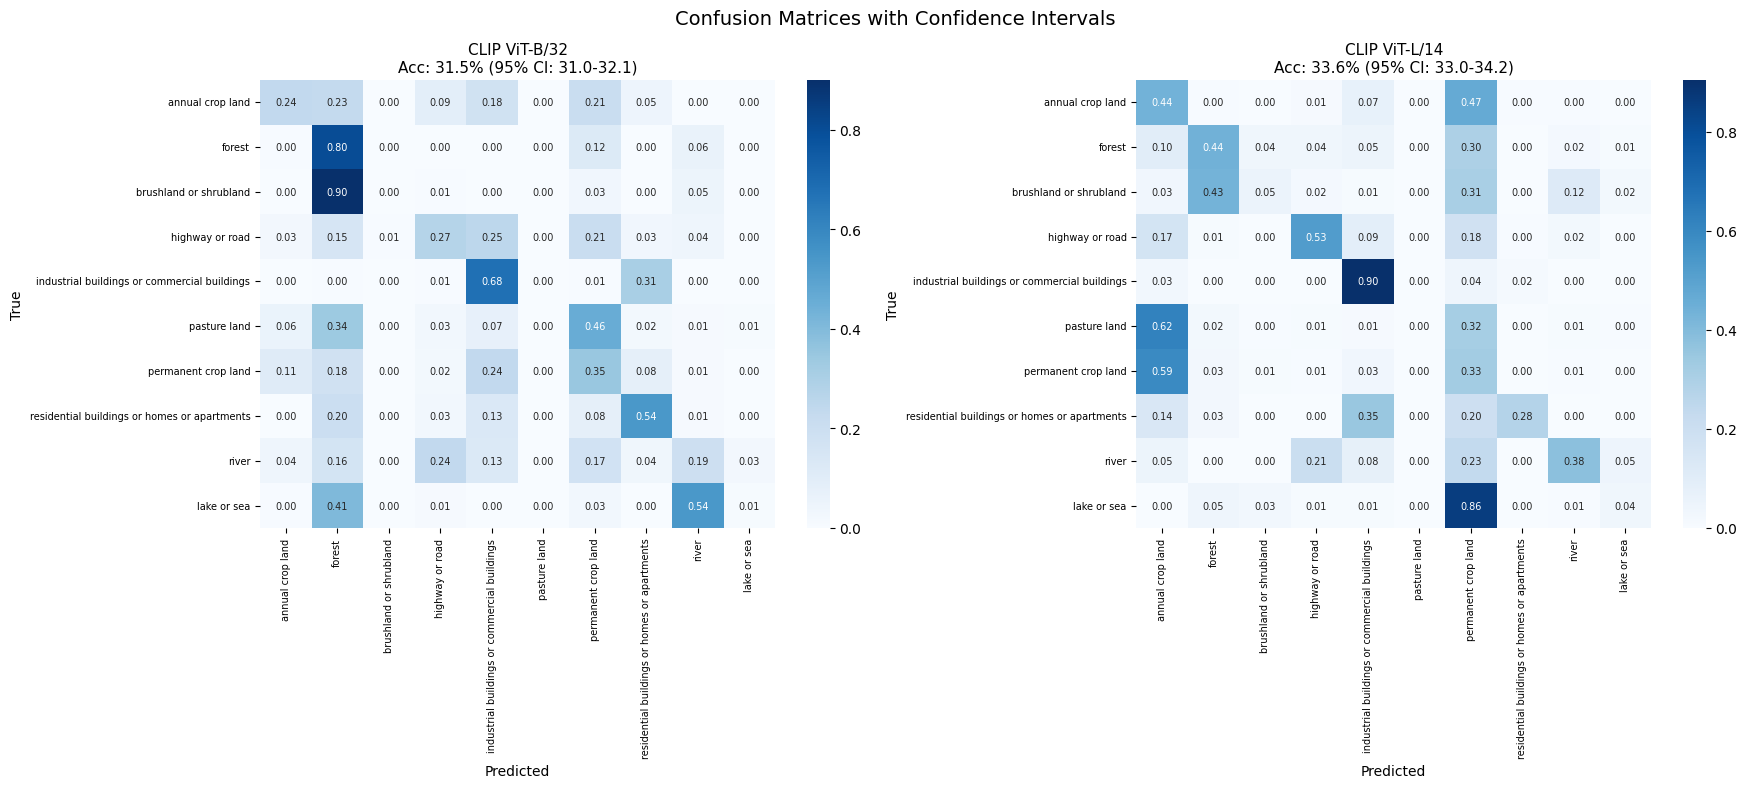

In [15]:
# Visualization: Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for ax, (model_name, data) in zip(axes, model_comparison.items()):
    cm = confusion_matrix(data['labels'], data['preds'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=ax,
                annot_kws={'size': 7})
    ci = data['ci']
    ax.set_title(f"{model_name}\nAcc: {data['acc']*100:.1f}% (95% CI: {ci[0]*100:.1f}-{ci[1]*100:.1f})", fontsize=11)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='both', labelsize=7)

plt.suptitle('Confusion Matrices with Confidence Intervals', fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig2_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

Extracting embeddings for t-SNE...


Extracting:   0%|          | 0/24 [00:00<?, ?it/s]

Computing t-SNE...


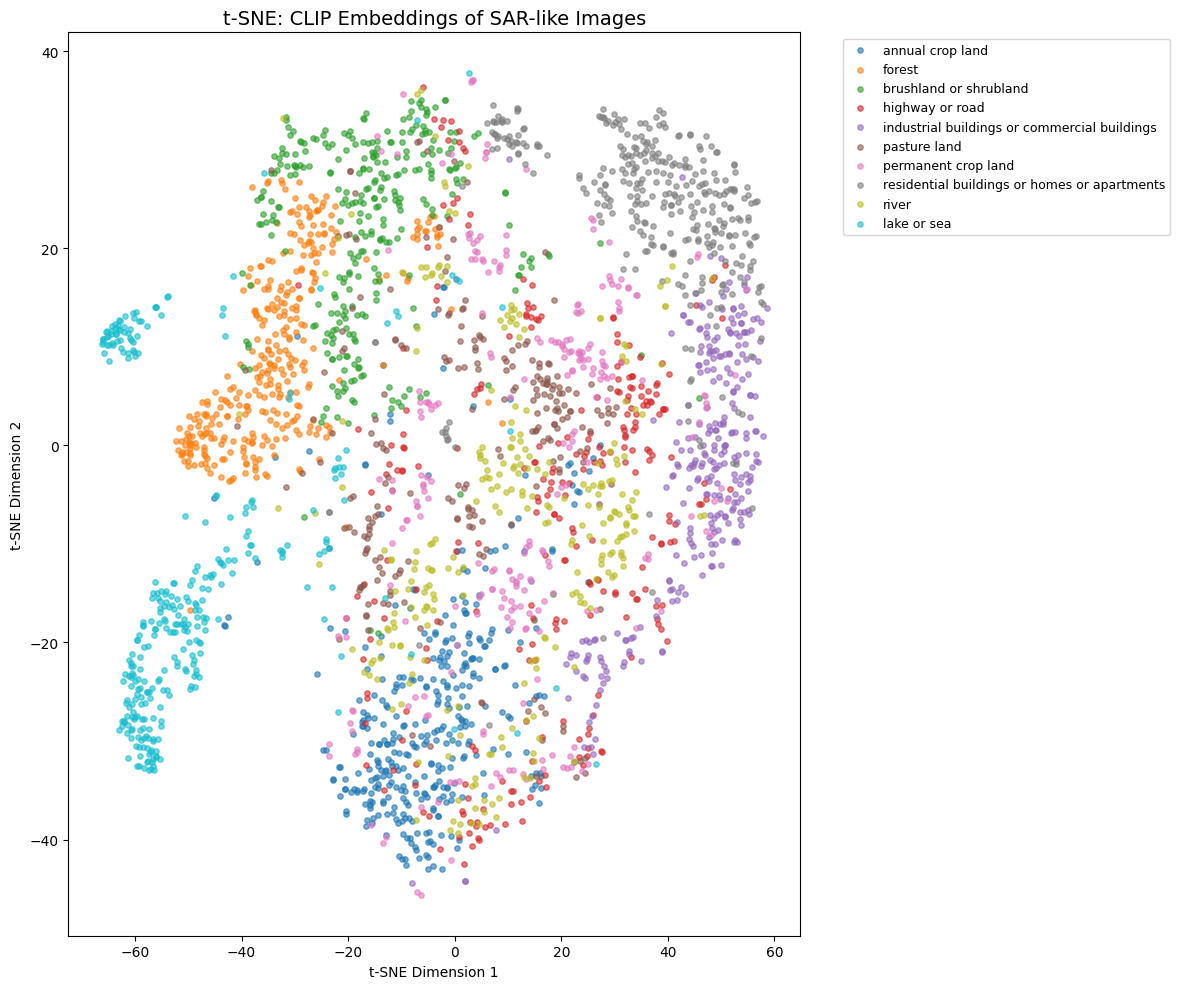

In [16]:
# t-SNE Embedding Visualization
print('Extracting embeddings for t-SNE...')

# Use subset for t-SNE (full is too slow)
tsne_subset = eurosat_full.shuffle(seed=42).select(range(3000))
tsne_dataset = EuroSATDataset(tsne_subset, preprocess_b32, use_grayscale=True)
tsne_loader = DataLoader(tsne_dataset, batch_size=128, shuffle=False)

all_embeddings = []
all_labels_tsne = []

with torch.no_grad():
    for images, labels, _ in tqdm(tsne_loader, desc='Extracting'):
        images = images.to(device)
        features = model_b32.encode_image(images)
        features = features / features.norm(dim=-1, keepdim=True)
        all_embeddings.append(features.cpu().numpy())
        all_labels_tsne.extend(labels.numpy())

embeddings = np.vstack(all_embeddings)
labels_tsne = np.array(all_labels_tsne)

print('Computing t-SNE...')
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

for i, class_name in enumerate(CLASS_NAMES):
    mask = labels_tsne == i
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
               c=[colors[i]], label=class_name, alpha=0.6, s=15)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.set_title('t-SNE: CLIP Embeddings of SAR-like Images', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fig3_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

## 📄 LaTeX Tables for Paper


In [17]:
# Generate LaTeX tables
print('='*60)
print('LATEX TABLE 1: Prompt Engineering Results')
print('='*60)
print(r'''
\begin{table}[h]
\centering
\caption{Zero-shot classification accuracy with different prompt templates (CLIP ViT-B/32)}
\label{tab:prompts}
\begin{tabular}{lcc}
\toprule
Prompt Template & Accuracy (\%) & 95\% CI \\
\midrule''')

for name in sorted(ci_results.keys(), key=lambda x: ci_results[x]['mean'], reverse=True):
    ci = ci_results[name]
    print(f"{name.replace('_', ' ').title()} & {ci['mean']*100:.2f} & [{ci['ci_low']*100:.2f}, {ci['ci_high']*100:.2f}] \\\\")

print(r'''\bottomrule
\end{tabular}
\end{table}
''')

LATEX TABLE 1: Prompt Engineering Results

\begin{table}[h]
\centering
\caption{Zero-shot classification accuracy with different prompt templates (CLIP ViT-B/32)}
\label{tab:prompts}
\begin{tabular}{lcc}
\toprule
Prompt Template & Accuracy (\%) & 95\% CI \\
\midrule
Aerial & 31.51 & [30.92, 32.07] \\
Texture Gray & 29.69 & [29.12, 30.30] \\
Ensemble & 29.64 & [29.07, 30.21] \\
Sentinel & 27.22 & [26.69, 27.81] \\
Photo & 27.09 & [26.54, 27.66] \\
Structure & 26.64 & [26.07, 27.23] \\
Sar Basic & 24.26 & [23.72, 24.79] \\
Generic & 23.90 & [23.38, 24.41] \\
Sar Texture & 23.81 & [23.27, 24.37] \\
Sar Physics & 23.70 & [23.16, 24.22] \\
Landcover & 22.02 & [21.49, 22.54] \\
\bottomrule
\end{tabular}
\end{table}



In [18]:
print('='*60)
print('LATEX TABLE 2: Model Comparison')
print('='*60)
print(r'''
\begin{table}[h]
\centering
\caption{Zero-shot classification accuracy comparison between CLIP models}
\label{tab:models}
\begin{tabular}{lccc}
\toprule
Model & Accuracy (\%) & 95\% CI & Parameters \\
\midrule
Random Baseline & 10.00 & - & - \\''')

for name, data in model_comparison.items():
    ci = data['ci']
    params = '86M' if 'B/32' in name else '304M'
    print(f"{name} & {data['acc']*100:.2f} & [{ci[0]*100:.2f}, {ci[1]*100:.2f}] & {params} \\\\")

print(r'''\bottomrule
\end{tabular}
\end{table}
''')

LATEX TABLE 2: Model Comparison

\begin{table}[h]
\centering
\caption{Zero-shot classification accuracy comparison between CLIP models}
\label{tab:models}
\begin{tabular}{lccc}
\toprule
Model & Accuracy (\%) & 95\% CI & Parameters \\
\midrule
Random Baseline & 10.00 & - & - \\
CLIP ViT-B/32 & 31.52 & [30.95, 32.11] & 86M \\
CLIP ViT-L/14 & 33.57 & [32.98, 34.17] & 304M \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
# Per-class results
print('='*60)
print('LATEX TABLE 3: Per-Class Performance')
print('='*60)

best_data = model_comparison['CLIP ViT-L/14']
report = classification_report(best_data['labels'], best_data['preds'], target_names=CLASS_NAMES, output_dict=True)

print(r'''
\begin{table}[h]
\centering
\caption{Per-class performance of CLIP ViT-L/14 on EuroSAT (grayscale)}
\label{tab:perclass}
\begin{tabular}{lccc}
\toprule
Class & Precision & Recall & F1-Score \\
\midrule''')

for cls in CLASS_NAMES:
    r = report[cls]
    print(f"{cls.replace('_', ' ').title()} & {r['precision']:.3f} & {r['recall']:.3f} & {r['f1-score']:.3f} \\\\")

print(r'''\midrule
Overall Accuracy & \multicolumn{3}{c}{''' + f"{report['accuracy']*100:.2f}\%" + r'''} \\
\bottomrule
\end{tabular}
\end{table}
''')

LATEX TABLE 3: Per-Class Performance

\begin{table}[h]
\centering
\caption{Per-class performance of CLIP ViT-L/14 on EuroSAT (grayscale)}
\label{tab:perclass}
\begin{tabular}{lccc}
\toprule
Class & Precision & Recall & F1-Score \\
\midrule
Annual Crop Land & 0.237 & 0.436 & 0.307 \\
Forest & 0.443 & 0.441 & 0.442 \\
Brushland Or Shrubland & 0.397 & 0.054 & 0.095 \\
Highway Or Road & 0.624 & 0.526 & 0.571 \\
Industrial Buildings Or Commercial Buildings & 0.531 & 0.905 & 0.669 \\
Pasture Land & 0.750 & 0.002 & 0.003 \\
Permanent Crop Land & 0.091 & 0.327 & 0.143 \\
Residential Buildings Or Homes Or Apartments & 0.916 & 0.276 & 0.424 \\
River & 0.634 & 0.382 & 0.476 \\
Lake Or Sea & 0.305 & 0.036 & 0.065 \\
\midrule
Overall Accuracy & \multicolumn{3}{c}{33.57\%} \\
\bottomrule
\end{tabular}
\end{table}



In [20]:
# Save all results
import json

final_results = {
    'dataset': 'EuroSAT',
    'num_samples': len(eurosat_full),
    'num_classes': NUM_CLASSES,
    'prompt_results': {k: {'accuracy': float(v['mean']), 'ci_low': float(v['ci_low']), 'ci_high': float(v['ci_high'])} for k, v in ci_results.items()},
    'model_results': {k: {'accuracy': float(v['acc']), 'ci_low': float(v['ci'][0]), 'ci_high': float(v['ci'][1])} for k, v in model_comparison.items()},
    'hierarchical_coarse_accuracy': float(coarse_acc),
    'mcnemar_p_value': float(p_value)
}

with open(f'{OUTPUT_DIR}/results_v2.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print('\n=== All Results Saved ===')
for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024
    print(f'  📊 {f} ({size:.1f} KB)')


=== All Results Saved ===
  📊 fig1_prompt_comparison_ci.png (266.8 KB)
  📊 fig2_confusion_matrices.png (449.9 KB)
  📊 fig3_tsne.png (1733.7 KB)
  📊 fig_hierarchical_coarse.png (185.3 KB)
  📊 results_v2.json (2.0 KB)


In [21]:
# Save to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import shutil
DRIVE_OUTPUT = '/content/drive/MyDrive/SAR image colorization/clip_results_v2'
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

for f in os.listdir(OUTPUT_DIR):
    shutil.copy2(os.path.join(OUTPUT_DIR, f), DRIVE_OUTPUT)

print(f'\n✅ All results saved to: {DRIVE_OUTPUT}')

Mounted at /content/drive

✅ All results saved to: /content/drive/MyDrive/SAR image colorization/clip_results_v2


# Visualization of SAR Simulation (V3)

Loading EuroSAT (Searching for diversity)...
Found AnnualCrop at index 0
Found Forest at index 2373
Found Highway at index 7144
Found Industrial at index 9156
Found River at index 17220


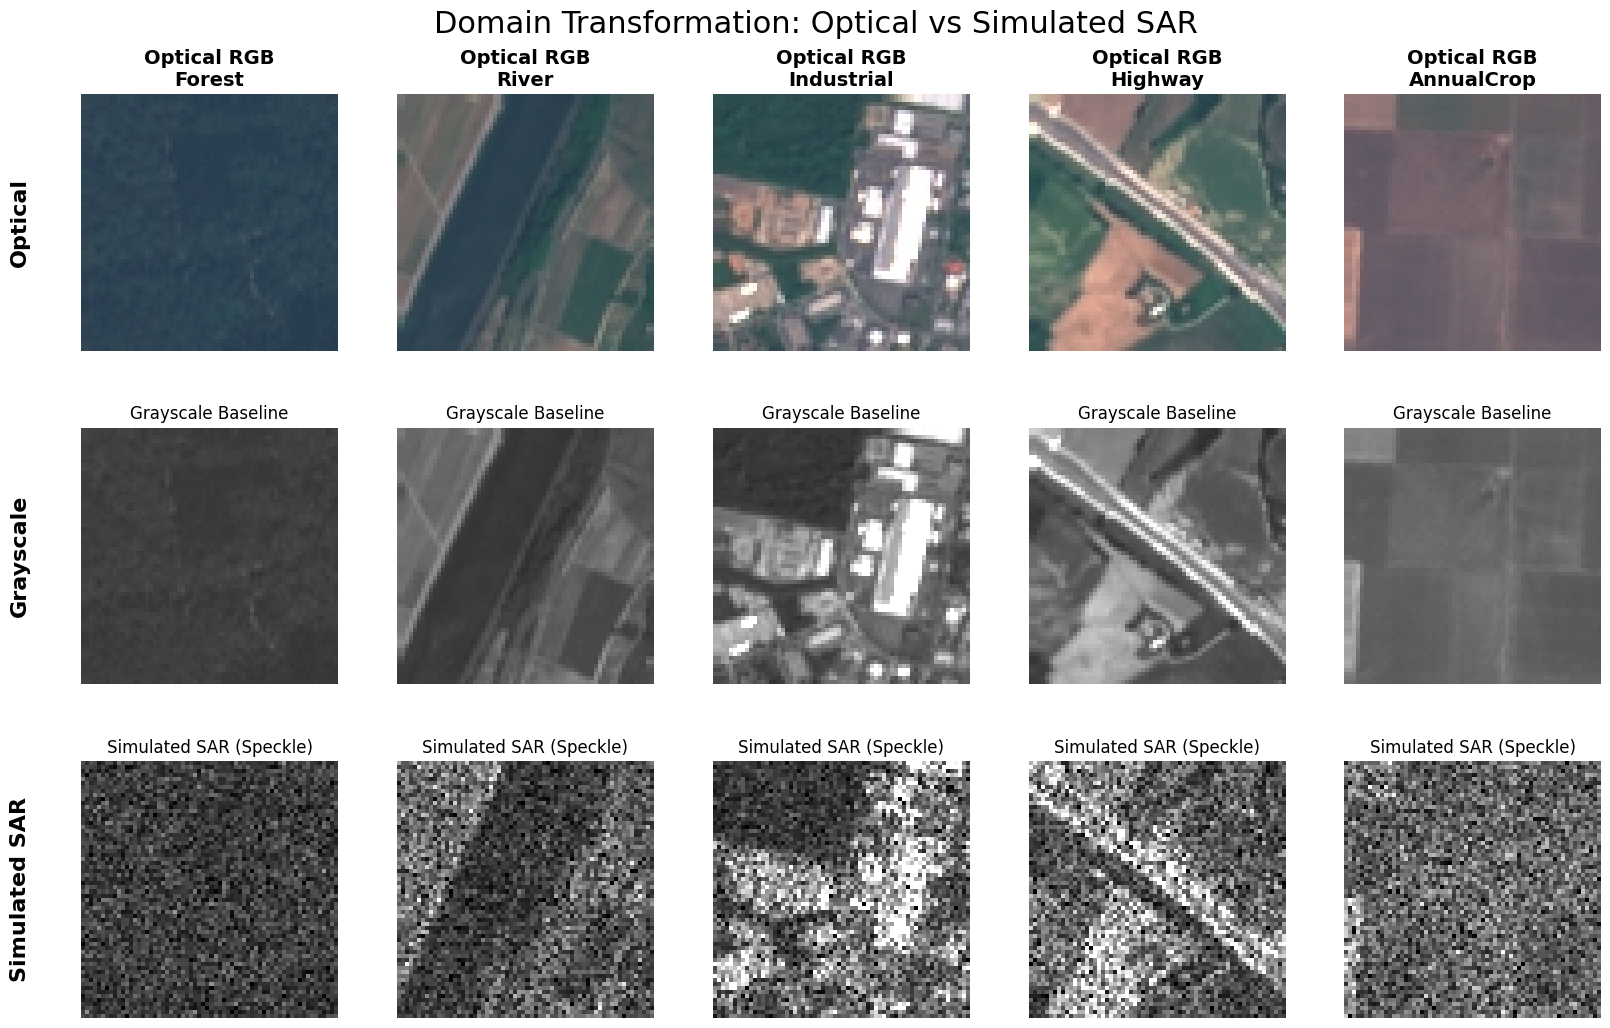

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from datasets import load_dataset

def add_speckle_noise_robust(img_gray):
    """Add multiplicative speckle noise to simulate SAR with high visibility."""
    img_array = np.array(img_gray) / 255.0
    # High variance for visibility
    noise = np.random.normal(0, 0.4, img_array.shape)
    noisy_img = img_array + img_array * noise
    noisy_img = np.clip(noisy_img, 0, 1)
    return Image.fromarray((noisy_img * 255).astype(np.uint8))

def visualize_sar_comparison_fixed():
    print("Loading EuroSAT (Searching for diversity)...")
    # Stream the dataset to iterate efficiently until we find what we need
    ds = load_dataset('tanganke/eurosat', split='train', streaming=True)

    target_classes = ['Forest', 'River', 'Industrial', 'Highway', 'AnnualCrop']
    # Manual map for robustness in streaming mode
    class_map = {
        0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway',
        4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential',
        8: 'River', 9: 'SeaLake'
    }

    found_images = {}

    # Iterate until we find all 5 target classes
    for i, item in enumerate(ds):
        label_id = item['label']
        label_name = class_map.get(label_id, str(label_id))

        if label_name in target_classes and label_name not in found_images:
            found_images[label_name] = item['image']
            print(f"Found {label_name} at index {i}")

        if len(found_images) == len(target_classes):
            break

    # Sort for consistent order
    label_order = target_classes

    # Configure Plot
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    for col, label in enumerate(label_order):
        # Fallback if class not found (unlikely with deep search)
        if label not in found_images: continue

        img_rgb = found_images[label]

        # 1. Optical (RGB)
        axes[0, col].imshow(np.array(img_rgb))
        axes[0, col].set_title(f"Optical RGB\n{label}", fontsize=14, fontweight='bold')
        axes[0, col].axis('off')

        # 2. Grayscale (Baseline)
        img_gray = img_rgb.convert('L')
        enhancer = ImageEnhance.Contrast(img_gray)
        img_gray_vis = enhancer.enhance(1.2) # Enhance for visibility

        axes[1, col].imshow(np.array(img_gray_vis), cmap='gray', vmin=0, vmax=255)
        axes[1, col].set_title(f"Grayscale Baseline", fontsize=12)
        axes[1, col].axis('off')

        # 3. Simulated SAR
        img_sar = add_speckle_noise_robust(img_gray_vis)
        axes[2, col].imshow(np.array(img_sar), cmap='gray', vmin=0, vmax=255)
        axes[2, col].set_title(f"Simulated SAR (Speckle)", fontsize=12)
        axes[2, col].axis('off')

    # Row labels
    rows = ['Optical', 'Grayscale', 'Simulated SAR']
    for ax, row in zip(axes[:,0], rows):
        ax.text(-0.2, 0.5, row, transform=ax.transAxes,
                va='center', ha='right', fontsize=16, fontweight='bold', rotation=90)

    plt.suptitle('Domain Transformation: Optical vs Simulated SAR', fontsize=22, y=0.95)
    plt.show()

# Run
visualize_sar_comparison_fixed()